In [9]:
# Install and import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleMLP()

In [12]:
import time

def train_model(model_class, optimizer_class, optimizer_params, criterion, train_loader, test_loader, epochs=5):
    model = model_class()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    train_losses = []
    val_accuracies = []
    val_losses = []
    batch_losses_last_epoch = []

    model.train()
    total_train_time = 0

    for epoch in range(epochs):
        running_loss = 0.0
        epoch_batch_losses = []
        start_epoch = time.time()

        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if epoch == epochs - 1:
                epoch_batch_losses.append(loss.item())

        end_epoch = time.time()
        total_train_time += (end_epoch - start_epoch)
        train_losses.append(running_loss / len(train_loader))

        # Validation loss and accuracy calculations
        model.eval()
        val_loss_sum = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss_sum / len(test_loader))
        val_accuracies.append(100 * correct / total)
        model.train()

        if epoch == epochs - 1:
            batch_losses_last_epoch = epoch_batch_losses

    return {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'val_losses': val_losses,
        'batch_losses_last_epoch': batch_losses_last_epoch,
        'total_train_time': total_train_time
    }


In [13]:
results = {}
criterion = nn.CrossEntropyLoss()

for name, (opt_class, opt_params) in {
    'SGD': (optim.SGD, {'lr': 0.01}),
    'SGD_Momentum': (optim.SGD, {'lr': 0.01, 'momentum': 0.9}),
    'RMSProp': (optim.RMSprop, {'lr': 0.01}),
    'Adam': (optim.Adam, {'lr': 0.01})
}.items():
    print(f"Training with {name}...")
    res = train_model(SimpleMLP, opt_class, opt_params, criterion, train_loader, test_loader, epochs=5)
    results[name] = res


Training with SGD...
Training with SGD_Momentum...
Training with RMSProp...
Training with Adam...


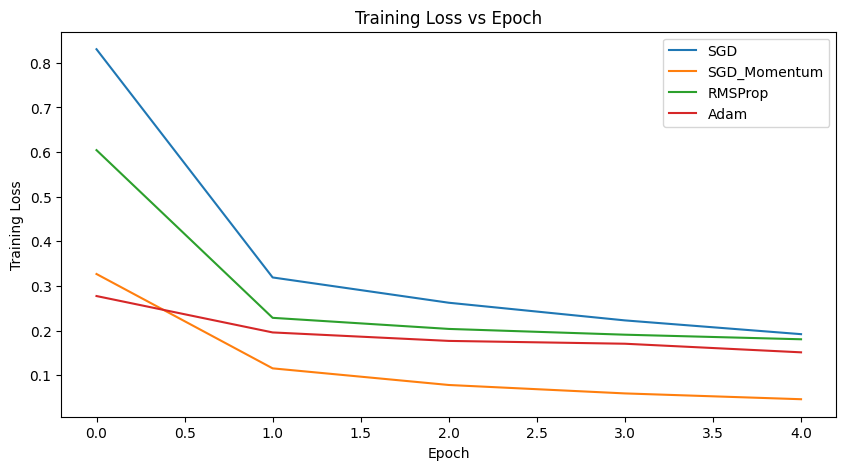

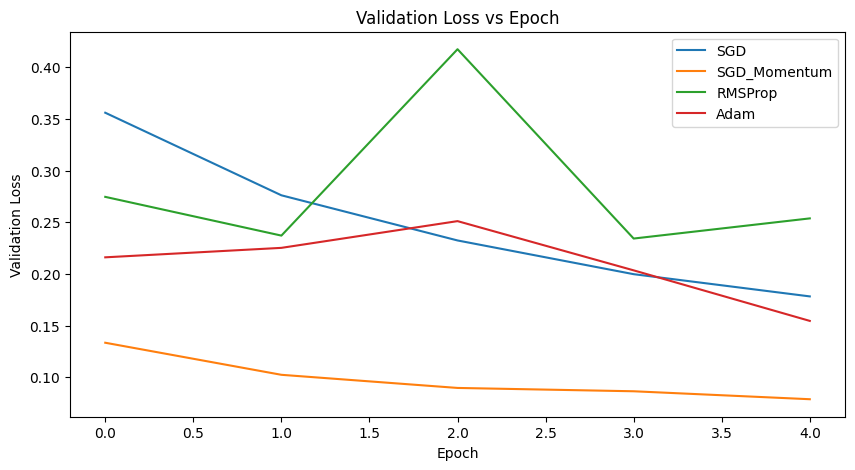

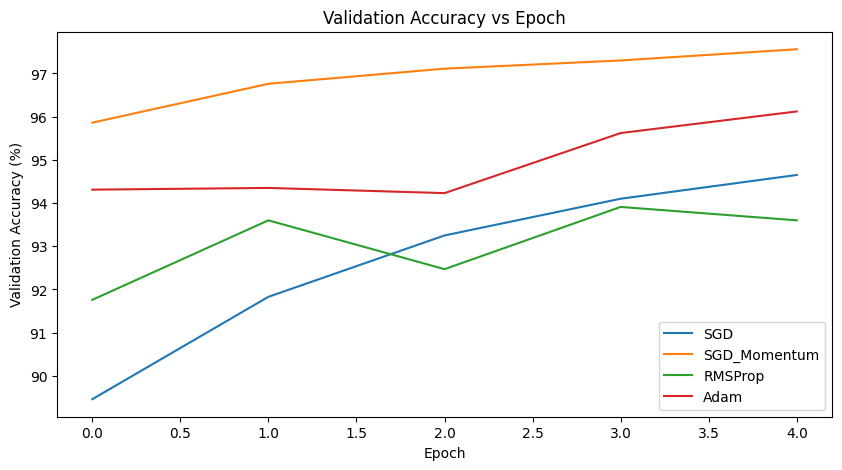

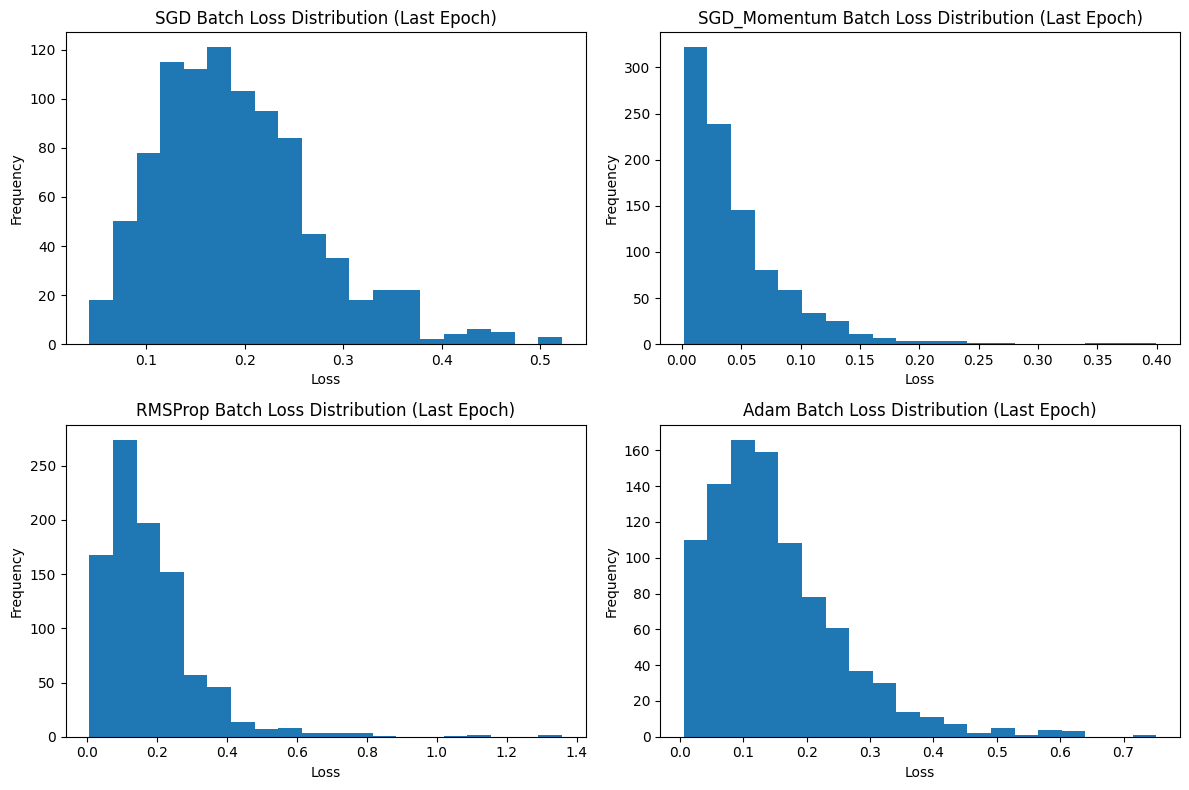

In [14]:
# Training Loss
plt.figure(figsize=(10, 5))
for name, data in results.items():
    plt.plot(data['train_losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

# Validation Loss
plt.figure(figsize=(10, 5))
for name, data in results.items():
    plt.plot(data['val_losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()
plt.show()

# Validation Accuracy
plt.figure(figsize=(10, 5))
for name, data in results.items():
    plt.plot(data['val_accuracies'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Epoch')
plt.legend()
plt.show()

# Batch Loss Distribution (last epoch)
plt.figure(figsize=(12, 8))
for i, (name, data) in enumerate(results.items()):
    plt.subplot(2, 2, i + 1)
    plt.hist(data['batch_losses_last_epoch'], bins=20)
    plt.title(f'{name} Batch Loss Distribution (Last Epoch)')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [15]:
comparison = []
for name, data in results.items():
    comparison.append({
        'Optimizer': name,
        'Final Accuracy': data['val_accuracies'][-1],
        'Best Accuracy': max(data['val_accuracies']),
        'Speed (Acc at Epoch 2)': data['val_accuracies'][1] if len(data['val_accuracies']) > 1 else 0,
        'Total Training Time (s)': round(data['total_train_time'], 2)
    })

df = pd.DataFrame(comparison)
df

,Optimizer,Final Accuracy,Best Accuracy,Speed (Acc at Epoch 2),Total Training Time (s)
0,SGD,94.65,94.65,91.83,85.70
1,SGD_Momentum,97.56,97.56,96.76,84.85
2,RMSProp,93.60,93.91,93.60,87.52
3,Adam,96.12,96.12,94.35,90.61
